In [1]:
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_hub as hub
from tensorflow.keras import layers
import pandas as pd
from keras.models import load_model
import pickle
from tensorflow.keras.optimizers import Adam 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm import tqdm

In [2]:
# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(31415)

# Loading data

In [3]:
# Load training, validation and test sets
ds_train_ = image_dataset_from_directory(
    'train',
    validation_split=0.2,
    seed=123,
    subset="training",
    image_size=(224, 224),
    interpolation = 'nearest',
    labels='inferred',
    shuffle=True,
)
ds_val_ = image_dataset_from_directory(
    'train',
    validation_split=0.2,
    seed=123,
    subset="validation",
    image_size=(224, 224),
    interpolation = 'nearest',
    labels='inferred',
    shuffle=True,
)
ds_test_ = image_dataset_from_directory(
    'test',
    image_size=(224, 224),
    interpolation = 'nearest',
    labels='inferred',
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_val = (
    ds_val_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_test = (
    ds_test_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-02-24 16:53:35.006568: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-24 16:53:35.006693: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.


# Getting insights

In [4]:
class_names = np.array(ds_train_.class_names)
print('There are\033[1m {}\033[0m classes:\033[1m'.format(len(class_names)))
for class_name in class_names:
    print('\t'+class_name.upper())
print("\033[0m", end="")

There are 7 classes:
	ANGRY
	DISGUST
	FEAR
	HAPPY
	NEUTRAL
	SAD
	SURPRISE


In [5]:
y_train = np.concatenate([y for x, y in ds_train], axis=0)
y_val = np.concatenate([y for x, y in ds_val], axis=0)
y_test = np.concatenate([y for x, y in ds_test], axis=0)

2023-02-24 16:53:36.196893: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


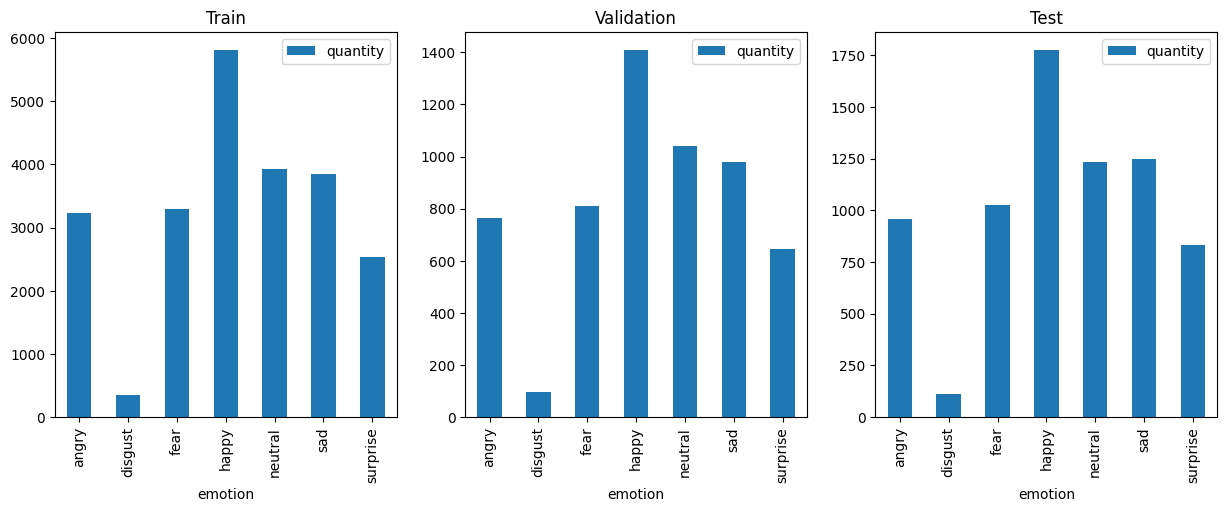

In [6]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
pd.DataFrame({'emotion':class_names[y_train], 'quantity': np.ones(y_train.shape)}).groupby('emotion').count().plot(ax=axes[0], kind='bar')
pd.DataFrame({'emotion':class_names[y_val], 'quantity': np.ones(y_val.shape)}).groupby('emotion').count().plot(ax=axes[1], kind='bar')
pd.DataFrame({'emotion':class_names[y_test], 'quantity': np.ones(y_test.shape)}).groupby('emotion').count().plot(ax=axes[2], kind='bar');

titles = ['Train','Validation','Test']
for i in range(3):
    axes[i].set_title(titles[i]); 

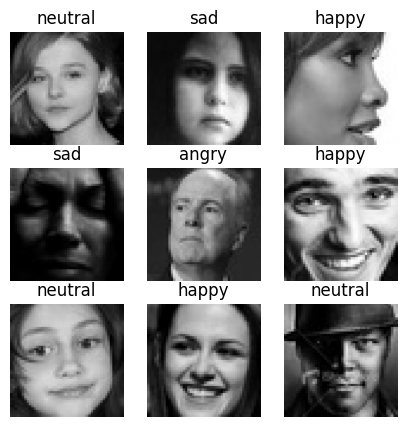

In [7]:
plt.figure(figsize=(5, 5))
for images, labels in ds_train_.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off");

# Training the model

In [8]:
# model = tf.keras.Sequential([
#                                 hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5",
#                                             trainable=False),
#                                 tf.keras.layers.Dense(len(class_names), activation='softmax')
#                             ])
# model.build([None, 224, 224, 3])
# model.summary()
# model.compile(
#     optimizer=Adam(lr=0.0001),
#     loss='sparse_categorical_crossentropy',
#     metrics=['accuracy'],
# )

# history = model.fit(
#     ds_train,
#     validation_data=ds_val,
#     epochs=30,
# )
# model.save('my_model.h5')
# with open('history.pkl', 'wb') as f:
#     pickle.dump(history.history, f)

In [9]:
model = load_model('my_model.h5',custom_objects={'KerasLayer':hub.KerasLayer})
with open('history.pkl', 'rb') as f:
    history2 = pickle.load(f)

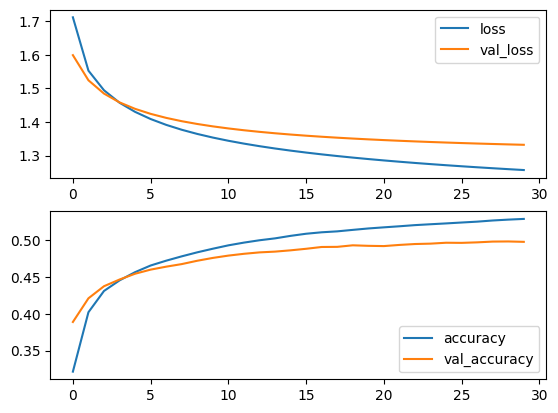

In [10]:
f,axes = plt.subplots(2)
history_frame = pd.DataFrame(history2)
history_frame.loc[:, ['loss', 'val_loss']].plot(ax=axes[0])
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot(ax=axes[1]);

# Evaluating the model

In [11]:
train_loss, train_accuracy = model.evaluate(ds_train)
val_loss, tval_accuracy = model.evaluate(ds_val)
test_loss, test_accuracy = model.evaluate(ds_test)

2023-02-24 16:53:44.374737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


225/225 [==============================] - 12s 51ms/step - loss: 1.3251 - accuracy: 0.4948


In [12]:
y_train_predictions = np.argmax(model.predict(ds_train),axis=1)
y_val_predictions = np.argmax(model.predict(ds_val),axis=1)
y_test_predictions = np.argmax(model.predict(ds_test),axis=1)

2023-02-24 16:54:42.512074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


225/225 [==============================] - 12s 51ms/step


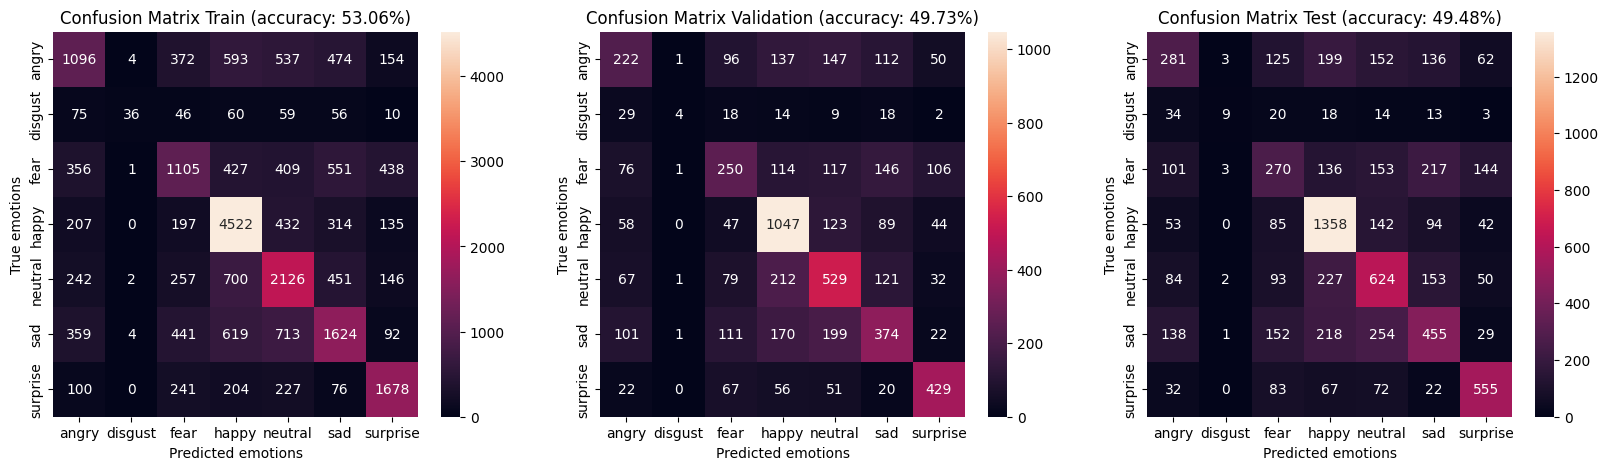

In [15]:
f, axes= plt.subplots(1,3,figsize=(20,5))
accuracies = []
accuracies.append(round(100*accuracy_score(y_train, y_train_predictions),2))
mat = confusion_matrix(y_train, y_train_predictions)
sns.heatmap(mat, annot=True, fmt='g', ax=axes[0]);

accuracies.append(round(100*accuracy_score(y_val, y_val_predictions),2))
mat = confusion_matrix(y_val, y_val_predictions)
sns.heatmap(mat, annot=True, fmt='g', ax=axes[1]);

accuracies.append(round(100*accuracy_score(y_test, y_test_predictions),2))
mat = confusion_matrix(y_test,y_test_predictions)
sns.heatmap(mat, annot=True, fmt='g', ax=axes[2]);

for i in range(3):
    axes[i].set_xlabel('Predicted emotions');axes[i].set_ylabel('True emotions'); 
    axes[i].set_title('Confusion Matrix '+titles[i]+ " (accuracy: {}%)".format(accuracies[i])); 
    axes[i].xaxis.set_ticklabels(class_names); axes[i].yaxis.set_ticklabels(class_names);

### There are very few "disgust" examples so they're the most difficult ones to predict, on the other hand "happy" is widely represented so it predicts them very well